### Tables & plots for paper

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score

In [ ]:
def calculate_metrics(df, significance_level=0.05):
    # Ensure ground_truth and p_value are present
    if "ground_truth" not in df.columns or "p_value" not in df.columns:
        raise ValueError("DataFrame must contain 'ground_truth' and 'p_value' columns.")

    # Calculate ROC AUC and PR AUC
    roc_auc = roc_auc_score(
        df["ground_truth"], -df["p_value"]
    )  # Negating p_value as lower is better
    pr_auc = average_precision_score(df["ground_truth"], -df["p_value"])

    # Calculate predictions based on significance level
    predictions = (df["p_value"] <= significance_level).astype(int)

    # Calculate Accuracy
    accuracy = (predictions == df["ground_truth"]).mean()

    # Calculate False Positive Rate (FPR)
    false_positives = ((predictions == 1) & (df["ground_truth"] == 0)).sum()
    true_negatives = (df["ground_truth"] == 0).sum()
    fpr = false_positives / true_negatives if true_negatives > 0 else 0.0

    return {
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Accuracy": accuracy,
        "FPR": fpr,
    }


def calculate_metrics_by_splits(df, significance_level=0.05, splits=4):
    """
    Calculate metrics for each split of user_size based on the specified number of splits.
    """
    # Sort the DataFrame by user_size
    df = df.sort_values("user_size").reset_index(drop=True)

    # Create splits based on user_size
    split_labels = [f"Split_{i+1}" for i in range(splits)]
    split_bins = pd.qcut(df["user_size"], q=splits, labels=split_labels)

    results = {}
    for split in split_labels:
        subset = df[split_bins == split]
        metrics = calculate_metrics(subset, significance_level)
        results[split] = metrics
        print(
            f"Split {split}: min={subset['user_size'].min()}, max={subset['user_size'].max()}"
        )

    return results


def print_results(results):
    margin = 0
    significance_level = 0.05
    splits = 4

    print(
        f'Test & reg set size are min={results["test_size"].min()}, max={results["test_size"].max()}'
    )
    margin_results = results[results["margin"] == margin]
    overall_metrics = calculate_metrics(
        margin_results, significance_level=significance_level
    )
    split_metrics = calculate_metrics_by_splits(
        margin_results, significance_level=significance_level, splits=splits
    )
    print("Overall Metrics:")
    print(overall_metrics)
    print("\nQuartile Metrics:")
    for split, metrics in split_metrics.items():
        print(f"{split}: {metrics}")

In [ ]:
results = pd.read_csv("suitability/results/sf_evals/fmow_sf_results_eff.csv")
print_results(results)
print(
    f"calibrated={results['calibrated'].unique()}, normalize={results['normalize'].unique()}"
)

Test & reg set size are min=1420, max=5268
Split Split_1: min=666, max=1620
Split Split_2: min=1747, max=3216
Split Split_3: min=3427, max=6149
Split Split_4: min=6165, max=15959
Overall Metrics:
{'ROC AUC': 0.9943307383816938, 'PR AUC': 0.985500230179584, 'Accuracy': 0.9597542242703533, 'FPR': 0.032908704883227176}

Quartile Metrics:
Split_1: {'ROC AUC': 0.9924087050012975, 'PR AUC': 0.9831688973098317, 'Accuracy': 0.940677966101695, 'FPR': 0.024691358024691357}
Split_2: {'ROC AUC': 0.9961738271604937, 'PR AUC': 0.9892229730033909, 'Accuracy': 0.986031746031746, 'FPR': 0.017777777777777778}
Split_3: {'ROC AUC': 0.9983604465709728, 'PR AUC': 0.9936465674157294, 'Accuracy': 0.9726495726495726, 'FPR': 0.02666666666666667}
Split_4: {'ROC AUC': 0.993100073960289, 'PR AUC': 0.9871714394208315, 'Accuracy': 0.9382978723404255, 'FPR': 0.07089947089947089}
calibrated=[ True], normalize=[ True]


In [ ]:
results = pd.read_csv("suitability/results/sf_evals/fmow_sf_results_eff_2.csv")
print_results(results)
print(
    f"calibrated={results['calibrated'].unique()}, normalize={results['normalize'].unique()}"
)

Test & reg set size are min=1420, max=5268
Split Split_1: min=666, max=1620
Split Split_2: min=1747, max=3216
Split Split_3: min=3427, max=6149
Split Split_4: min=6165, max=15959
Overall Metrics:
{'ROC AUC': 0.9865173978542033, 'PR AUC': 0.9708024972927135, 'Accuracy': 0.9344444444444444, 'FPR': 0.03214285714285714}

Quartile Metrics:
Split_1: {'ROC AUC': 0.9880553275573795, 'PR AUC': 0.9761410396549028, 'Accuracy': 0.9057291666666667, 'FPR': 0.021176470588235293}
Split_2: {'ROC AUC': 0.9801424501424502, 'PR AUC': 0.9604691380795279, 'Accuracy': 0.9327380952380953, 'FPR': 0.037606837606837605}
Split_3: {'ROC AUC': 0.9958047619047619, 'PR AUC': 0.986247329506067, 'Accuracy': 0.9682291666666667, 'FPR': 0.02}
Split_4: {'ROC AUC': 0.9874924872185147, 'PR AUC': 0.9765397144885785, 'Accuracy': 0.9303571428571429, 'FPR': 0.05570776255707763}
calibrated=[False], normalize=[False]


In [ ]:
results = pd.read_csv("suitability/results/sf_evals/fmow_sf_results_eff_3.csv")
print_results(results)
print(
    f"calibrated={results['calibrated'].unique()}, normalize={results['normalize'].unique()}"
)

Test & reg set size are min=1420, max=5268
Split Split_1: min=666, max=1620
Split Split_2: min=1747, max=3216
Split Split_3: min=3427, max=6149
Split Split_4: min=6165, max=15959
Overall Metrics:
{'ROC AUC': 0.9844283693415639, 'PR AUC': 0.9651548521017159, 'Accuracy': 0.9347222222222222, 'FPR': 0.050793650793650794}

Quartile Metrics:
Split_1: {'ROC AUC': 0.985701170390637, 'PR AUC': 0.9704355883814164, 'Accuracy': 0.9229166666666667, 'FPR': 0.04}
Split_2: {'ROC AUC': 0.9810390480978717, 'PR AUC': 0.959324814590798, 'Accuracy': 0.9517857142857142, 'FPR': 0.02905982905982906}
Split_3: {'ROC AUC': 0.9941460317460317, 'PR AUC': 0.9801845680663184, 'Accuracy': 0.9552083333333333, 'FPR': 0.042666666666666665}
Split_4: {'ROC AUC': 0.9815431448308161, 'PR AUC': 0.9675029272362372, 'Accuracy': 0.9077380952380952, 'FPR': 0.09771689497716896}
calibrated=[False], normalize=[ True]


In [ ]:
results = pd.read_csv("suitability/results/sf_evals/fmow_sf_results_eff_4.csv")
print_results(results)
print(
    f"calibrated={results['calibrated'].unique()}, normalize={results['normalize'].unique()}"
)

Test & reg set size are min=1420, max=5268
Split Split_1: min=666, max=1620
Split Split_2: min=1747, max=3216
Split Split_3: min=3427, max=6149
Split Split_4: min=6165, max=15959
Overall Metrics:
{'ROC AUC': 0.9864740410052909, 'PR AUC': 0.970731077150154, 'Accuracy': 0.9352777777777778, 'FPR': 0.03194444444444444}

Quartile Metrics:
Split_1: {'ROC AUC': 0.987703906368749, 'PR AUC': 0.9755076340691106, 'Accuracy': 0.9036458333333334, 'FPR': 0.02196078431372549}
Split_2: {'ROC AUC': 0.9801039048097872, 'PR AUC': 0.9603790543687072, 'Accuracy': 0.9345238095238095, 'FPR': 0.038461538461538464}
Split_3: {'ROC AUC': 0.9957396825396825, 'PR AUC': 0.9860093612479633, 'Accuracy': 0.96875, 'FPR': 0.02}
Split_4: {'ROC AUC': 0.9877922179292042, 'PR AUC': 0.9770398950714636, 'Accuracy': 0.9339285714285714, 'FPR': 0.052968036529680365}
calibrated=[ True], normalize=[False]


/tmp/ipykernel_54942/466121645.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_counts = check.groupby('diff_bin')['error'].sum()


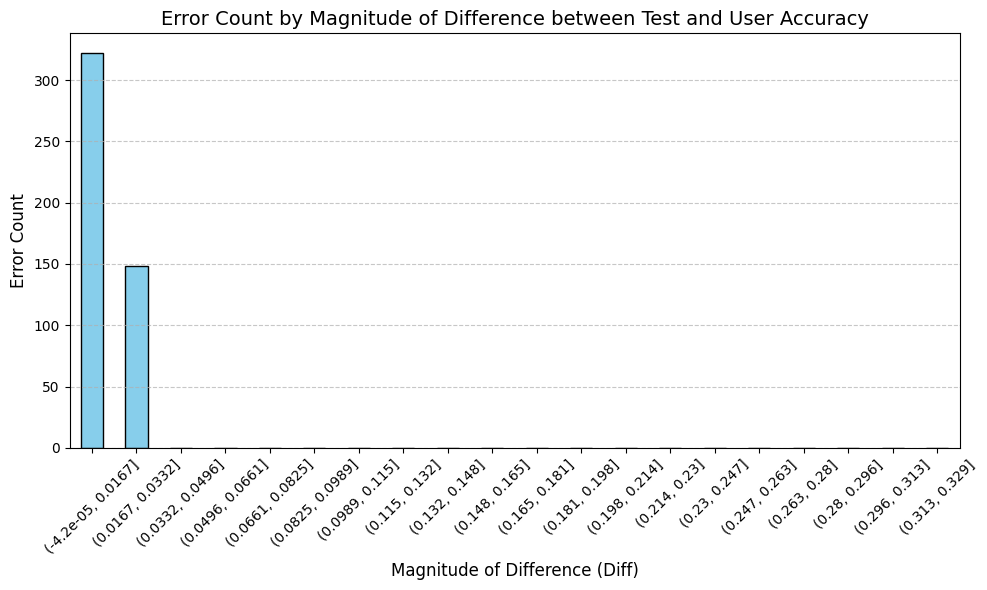

In [ ]:
# Copy results and calculate diff and error
check = results[results["margin"] == 0].copy()
check["diff"] = np.abs(check["user_acc"] - check["test_acc"])

# Define error based on conditions
check["error"] = ((check["ground_truth"] == False) & (check["p_value"] <= 0.05)) | (
    (check["ground_truth"] == True) & (check["p_value"] > 0.05)
)

# Create bins for diff
num_bins = 20  # Number of bins (can adjust as needed)
check["diff_bin"] = pd.cut(check["diff"], bins=num_bins)

# Count the number of errors in each bin
error_counts = check.groupby("diff_bin")["error"].sum()

# Plot the results
plt.figure(figsize=(10, 6))
error_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title(
    "Error Count by Magnitude of Difference between Test and User Accuracy", fontsize=14
)
plt.xlabel("Magnitude of Difference (Diff)", fontsize=12)
plt.ylabel("Error Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
check["error"].unique()

array([ True, False])